1 validation on sample.nc like merra2<br>
2 after 3d is completed, use model interface<br>
3 njit

In [1]:
from numba import njit, prange
import numpy as np
import warnings
import xarray as xr
warnings.filterwarnings('ignore')

In [2]:
@njit(parallel=True)
def interpolate_speeds(speed_data, heights_data, target_heights_data):
    n_times, n_levels, n_lat, n_lon = speed_data.shape
    interpolated = np.empty((n_times, len(target_heights_data), n_lat, n_lon))
    
    for i in prange(n_times):
        for j in prange(len(target_heights_data)):
            for k in prange(n_lat):
                for l in prange(n_lon):
                    target = target_heights_data[l]
                    # Find bracketing heights
                    for m in prange(n_levels-1):
                        if heights_data[m] <= target <= heights_data[m+1]:
                            # Linear interpolation
                            frac = (target - heights_data[m]) / (heights_data[m+1] - heights_data[m])
                            interpolated[i, j, k, l] = speed_data[i, j, k, m] + frac * (speed_data[i, j, k, m+1] - speed_data[i, j, k, m])
                            break
    return interpolated

In [3]:
ds2 = xr.open_dataset('./sample.nc')

In [4]:
u = ds2['u'].values
v = ds2['v'].values
levels = ds2['level'].values
wind_speed = np.sqrt(u**2 + v**2)

In [5]:
target_heights = np.array([132.5, 134.5])

In [6]:
interpolated_wind_speed = interpolate_speeds(wind_speed, levels, target_heights)

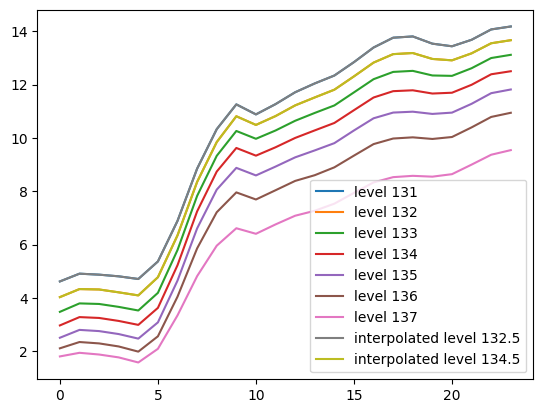

In [7]:
# time level lat lon
import matplotlib.pyplot as plt
plt.plot(wind_speed[:, 0, 0, 0], label = 'level 131');
plt.plot(wind_speed[:, 1, 0, 0], label = 'level 132');
plt.plot(wind_speed[:, 2, 0, 0], label = 'level 133');
plt.plot(wind_speed[:, 3, 0, 0], label = 'level 134');
plt.plot(wind_speed[:, 4, 0, 0], label = 'level 135');
plt.plot(wind_speed[:, 5, 0, 0], label = 'level 136');
plt.plot(wind_speed[:, 6, 0, 0], label = 'level 137');
plt.plot(interpolated_wind_speed[:, 0, 0, 0], label = 'interpolated level 132.5');
plt.plot(interpolated_wind_speed[:, 1, 0, 0], label = 'interpolated level 134.5');
plt.legend()
plt.show()

### ERA5 Testing

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
import geodata
from geodata.model.wind import WindInterpolationModel

In [ ]:
DS = geodata.Dataset(
    module="era5",
    weather_data_config="wind_solar_hourly",
    years=slice(2005, 2005),
    months=slice(1,1),
    bounds=[50, -3, 45, 3]
)

In [ ]:
model = WindInterpolationModel(DS)
model.prepare()

In [ ]:
model.estimate(
    height=2,
    years=slice(2010, 2010),
    months=slice(1, 1)
)
# /Users/apple/.local/geodata/models/wind/era5/nc4/2005/01/05.params.nc4, 05 = date

In [ ]:
# def interpolate_wind_speed_cs(speed_data, heights, target_height):
#     cs = CubicSpline(heights, speed_data, axis=0)
#     interpolated_wind_speed = cs(target_height)
    
#     return interpolated_wind_speed

In [ ]:
# cs_speed = interpolate_wind_speed_cs(wind_speed[0, :, 0, 0], levels, 132.5)